Using DATA_DIR = C:\Users\punna\Downloads\kmeans_data
Data shape: 10000 x 784 | #classes (K): 10


,distance,stop_mode,sse,iters,time_sec,accuracy
0,euclidean,nocentroid_or_sseup,2.532360e+10,32,28.495237,0.6018
1,euclidean,nocentroid,2.532360e+10,32,30.326800,0.6018
2,euclidean,sse_up,2.532360e+10,500,444.689638,0.6018
3,euclidean,maxiter,2.532360e+10,500,423.975841,0.6018
4,cosine,nocentroid_or_sseup,2.546523e+10,31,18.725013,0.5805
5,cosine,nocentroid,2.541783e+10,118,81.667598,0.6138
6,cosine,sse_up,2.546523e+10,31,20.280478,0.5805
7,cosine,maxiter,2.541783e+10,500,345.793628,0.6138
8,jaccard,nocentroid_or_sseup,2.567009e+10,25,50.206110,0.5823
9,jaccard,nocentroid,2.566971e+10,28,56.059802,0.5823


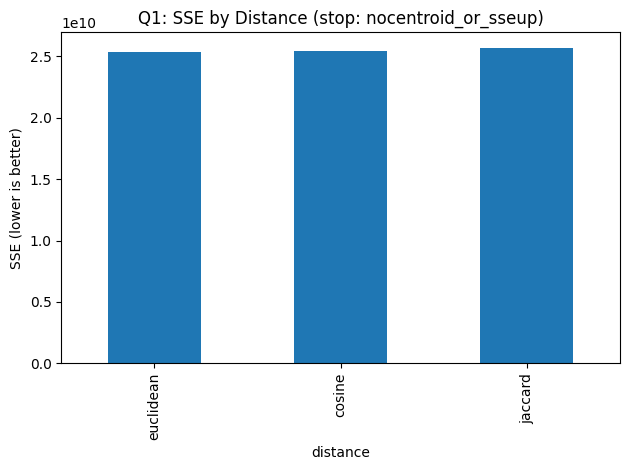

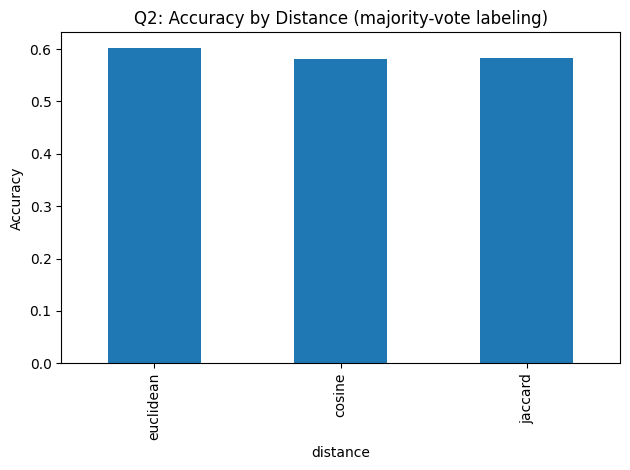

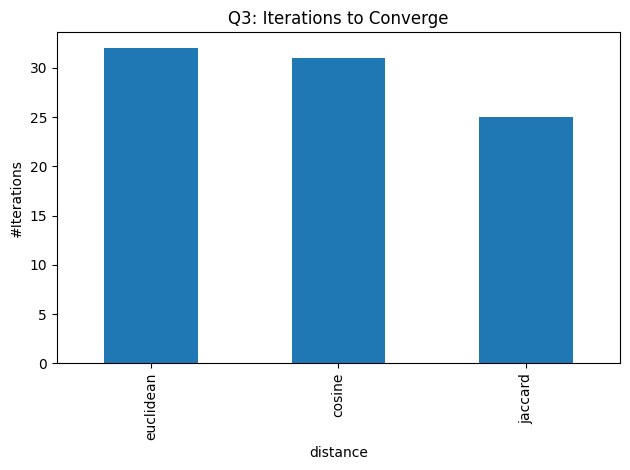

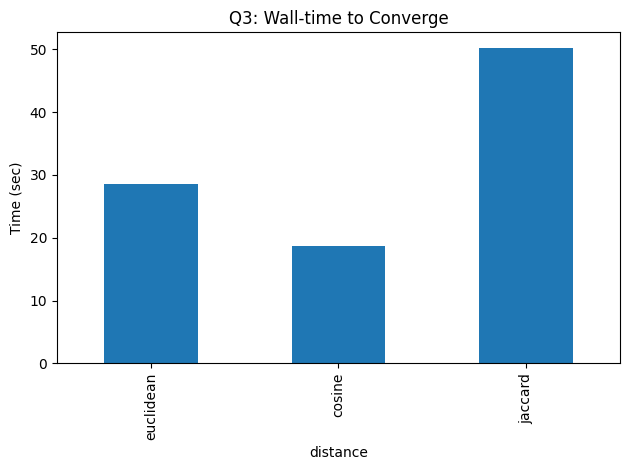

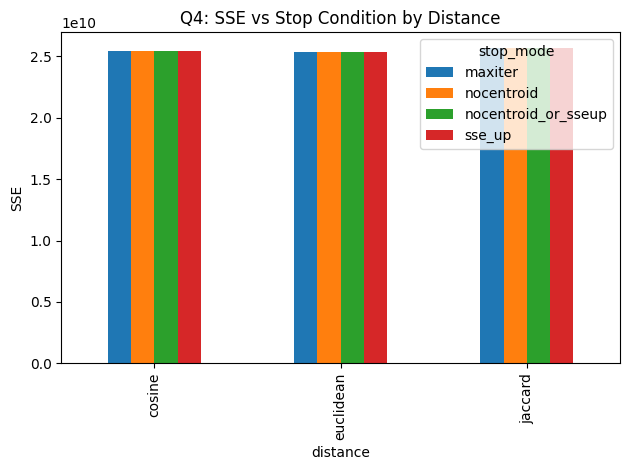

Saved metrics to outputs/task1/metrics_task1.csv
Saved plots to C:\Users\punna\outputs\task1\plots


In [1]:
# === Task 1 — K-Means (Euclidean / 1−Cosine / Generalized Jaccard) ===
# Ready-to-run Jupyter cell. Edit DATA_DIR if needed.

from pathlib import Path
import time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------- Config ----------------------
DATA_DIR = Path(r"C:\Users\punna\Downloads\kmeans_data")  # <- change if needed
OUT_DIR = Path("outputs/task1/plots"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# Optional fallback to uploaded files in this environment (e.g., if testing here)
_fallback = Path("/mnt/data")
if not (DATA_DIR / "data.csv").exists() and (_fallback / "data.csv").exists():
    DATA_DIR = _fallback
print("Using DATA_DIR =", DATA_DIR.resolve())

# ---------------------- Load data ----------------------
# Expect: data.csv (N x D), label.csv (N x 1)
X = pd.read_csv(DATA_DIR / "data.csv", header=None).values.astype(float)
y = pd.read_csv(DATA_DIR / "label.csv", header=None).values.squeeze().astype(int)
N, D = X.shape
K = len(np.unique(y))
print(f"Data shape: {N} x {D} | #classes (K): {K}")

# ---------------------- Distances ----------------------
def euclidean(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.sqrt(np.sum((a - b) ** 2)))

def cosine_distance(a: np.ndarray, b: np.ndarray) -> float:
    # 1 - cosine similarity
    na = np.linalg.norm(a); nb = np.linalg.norm(b)
    if na == 0 or nb == 0: return 1.0
    return float(1.0 - (a @ b) / (na * nb))

def generalized_jaccard_distance(a: np.ndarray, b: np.ndarray) -> float:
    # 1 - sum(min)/sum(max), shift if negatives appear
    amin = min(a.min(), b.min())
    if amin < 0:
        a = a - amin
        b = b - amin
    num = np.sum(np.minimum(a, b))
    den = np.sum(np.maximum(a, b))
    if den == 0: return 0.0
    return float(1.0 - num / den)

DIST = {
    "euclidean": euclidean,
    "cosine": cosine_distance,
    "jaccard": generalized_jaccard_distance,
}

# ---------------------- K-Means (from scratch) ----------------------
def kmeans(X: np.ndarray, K: int, dist_name: str, max_iter: int = 500,
           stop_mode: str = "nocentroid_or_sseup", random_state: int = 42):
    """
    stop_mode in {"nocentroid", "sse_up", "maxiter", "nocentroid_or_sseup"}
    Returns: (labels, centroids, stats_dict)
    """
    rng = np.random.default_rng(random_state)
    N, D = X.shape

    # k-means++ initialization
    centroids = np.empty((K, D), dtype=float)
    centroids[0] = X[rng.integers(N)]
    d2 = np.full(N, np.inf)
    for k in range(1, K):
        d2 = np.minimum(d2, np.sum((X - centroids[k-1])**2, axis=1))
        probs = d2 / d2.sum()
        centroids[k] = X[rng.choice(N, p=probs)]
    labels = np.zeros(N, dtype=int)

    def assign():
        dmat = np.zeros((N, K))
        for k in range(K):
            if dist_name == "euclidean":
                dmat[:, k] = np.sqrt(((X - centroids[k])**2).sum(axis=1))
            elif dist_name == "cosine":
                a = X; b = centroids[k]
                na = np.linalg.norm(a, axis=1); nb = np.linalg.norm(b)
                denom = na * (nb if nb != 0 else 1.0)
                sim = (a @ b) / np.where(denom == 0, 1.0, denom)
                dmat[:, k] = 1.0 - sim
            else:  # generalized jaccard
                dmat[:, k] = [generalized_jaccard_distance(xi, centroids[k]) for xi in X]
        new_labels = np.argmin(dmat, axis=1)
        # Keep a consistent compactness score using Euclidean SSE
        sse = float(np.sum((X - centroids[new_labels])**2))
        return new_labels, sse

    def update():
        new_centroids = np.zeros_like(centroids)
        for k in range(K):
            members = X[labels == k]
            if len(members) == 0:
                new_centroids[k] = X[rng.integers(N)]
            else:
                new_centroids[k] = members.mean(axis=0)
        return new_centroids

    start = time.time()
    prev_sse = math.inf
    iters = 0
    for it in range(1, max_iter + 1):
        labels, sse = assign()
        new_centroids = update()

        no_centroid_change = np.allclose(new_centroids, centroids)
        sse_up = sse > prev_sse

        centroids = new_centroids
        prev_sse = sse
        iters = it

        if stop_mode == "nocentroid" and no_centroid_change:
            break
        if stop_mode == "sse_up" and sse_up:
            break
        if stop_mode == "nocentroid_or_sseup" and (no_centroid_change or sse_up):
            break
        if stop_mode == "maxiter" and it == max_iter:
            break

    elapsed = time.time() - start
    return labels, centroids, {"sse": float(prev_sse), "iters": iters, "time_sec": float(elapsed)}

def majority_vote_accuracy(labels: np.ndarray, y: np.ndarray, K: int) -> float:
    acc = 0
    for k in range(K):
        idx = np.where(labels == k)[0]
        if len(idx) == 0: 
            continue
        votes, counts = np.unique(y[idx], return_counts=True)
        maj = votes[np.argmax(counts)]
        acc += np.sum(y[idx] == maj)
    return acc / len(y)

# ---------------------- Run experiments ----------------------
rows = []
dists = ["euclidean", "cosine", "jaccard"]
stops = ["nocentroid_or_sseup", "nocentroid", "sse_up", "maxiter"]

for dist_name in dists:
    for stop in stops:
        labels, centroids, stats = kmeans(X, K, dist_name, stop_mode=stop, max_iter=500, random_state=42)
        acc = majority_vote_accuracy(labels, y, K)
        rows.append({
            "distance": dist_name,
            "stop_mode": stop,
            "sse": stats["sse"],
            "iters": stats["iters"],
            "time_sec": stats["time_sec"],
            "accuracy": acc,
        })

df = pd.DataFrame(rows)
Path("outputs/task1").mkdir(parents=True, exist_ok=True)
df.to_csv("outputs/task1/metrics_task1.csv", index=False)
display(df)

# ---------------------- Plots ----------------------
sub = df[df["stop_mode"] == "nocentroid_or_sseup"]

ax = sub.plot(kind="bar", x="distance", y="sse", legend=False)
plt.ylabel("SSE (lower is better)")
plt.title("Q1: SSE by Distance (stop: nocentroid_or_sseup)")
plt.tight_layout(); plt.savefig(OUT_DIR / "q1_sse_by_distance.png"); plt.show()

if not sub["accuracy"].isna().all():
    ax = sub.plot(kind="bar", x="distance", y="accuracy", legend=False)
    plt.ylabel("Accuracy")
    plt.title("Q2: Accuracy by Distance (majority-vote labeling)")
    plt.tight_layout(); plt.savefig(OUT_DIR / "q2_accuracy_by_distance.png"); plt.show()

ax = sub.plot(kind="bar", x="distance", y="iters", legend=False)
plt.ylabel("#Iterations")
plt.title("Q3: Iterations to Converge")
plt.tight_layout(); plt.savefig(OUT_DIR / "q3_iters.png"); plt.show()

ax = sub.plot(kind="bar", x="distance", y="time_sec", legend=False)
plt.ylabel("Time (sec)")
plt.title("Q3: Wall-time to Converge")
plt.tight_layout(); plt.savefig(OUT_DIR / "q3_time.png"); plt.show()

pivot = df.pivot_table(index=["distance"], columns="stop_mode", values="sse", aggfunc="mean")
ax = pivot.plot(kind="bar")
plt.ylabel("SSE")
plt.title("Q4: SSE vs Stop Condition by Distance")
plt.tight_layout(); plt.savefig(OUT_DIR / "q4_sse_vs_stop.png"); plt.show()

print("Saved metrics to outputs/task1/metrics_task1.csv")
print("Saved plots to", OUT_DIR.resolve())
